In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Get data into dataframe
df = pd.read_csv('WMA_fractions_v2.csv', skiprows=1)

# Preprocess data to only have temperature, salinity and dissolved oxygen
df_TSO = df.copy()
df_TSO = df_TSO[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]', 'Latitude_[deg_N]', 'Longitude_[deg_E]']]
# df_TSO = df_TSO[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]']]
df_TSO = df_TSO.dropna()

In [4]:
df['Source'].unique()

array(['argo', 'glodap', 'udash', 'itp', 'MOSAiC'], dtype=object)

In [44]:
# Sample data

import pandas as pd
import numpy as np

def sample_by_lat_lon_bins(
    df,
    bin_sizes=(2, 2),
    total_samples=None,
    fraction=None,
    strategy="equal",   # "equal" or "proportional"
    replace=False,
    random_state=None
):
    lat_size, lon_size = bin_sizes

    # Determine how many samples
    if fraction is not None:
        total_samples = int(round(len(df) * fraction))
    if total_samples is None:
        total_samples = len(df)

    df = df.copy()

    # Build bins
    lat_bins = np.arange(df.lat.min(), df.lat.max() + lat_size, lat_size)
    lon_bins = np.arange(df.lon.min(), df.lon.max() + lon_size, lon_size)

    df["_lat_bin"] = pd.cut(df["lat"], bins=lat_bins, include_lowest=True)
    df["_lon_bin"] = pd.cut(df["lon"], bins=lon_bins, include_lowest=True)

    # Drop unbinned rows
    df_binned = df.dropna(subset=["_lat_bin", "_lon_bin"])

    # Group by bins
    grouped = df_binned.groupby(["_lat_bin", "_lon_bin"], observed=True)

    # Extract bin info directly from the groups
    bins = []
    counts = []
    for key, group in grouped:
        bins.append(key)          # key = (lat_interval, lon_interval)
        counts.append(len(group))

    bin_info = pd.DataFrame({"bin": bins, "count": counts})
    n_bins = len(bin_info)

    # Allocate samples
    if strategy == "equal":
        base = total_samples // n_bins
        remainder = total_samples - base * n_bins
        bin_info["target"] = base
        if remainder > 0:
            bin_info.loc[:remainder - 1, "target"] += 1

    elif strategy == "proportional":
        total_count = bin_info["count"].sum()
        raw = bin_info["count"] / total_count * total_samples
        bin_info["target"] = np.floor(raw).astype(int)
        remainder = total_samples - bin_info["target"].sum()
        if remainder > 0:
            frac = raw - np.floor(raw)
            idx = np.argsort(-frac)[:remainder]
            bin_info.loc[idx, "target"] += 1

    else:
        raise ValueError("strategy must be 'equal' or 'proportional'")

    # --- SAMPLE ---
    sampled_parts = []
    for (lat_bin, lon_bin), target in zip(bin_info["bin"], bin_info["target"]):
        group = grouped.get_group((lat_bin, lon_bin))

        # Sample without replacement until group limit
        if (len(group) < target) and not replace:
            sampled_parts.append(group)
        else:
            sampled_parts.append(group.sample(target, replace=replace, random_state=random_state))

    sampled_df = pd.concat(sampled_parts).reset_index(drop=True)

    # Clean temporary columns
    sampled_df = sampled_df.drop(columns=["_lat_bin", "_lon_bin"])

    return sampled_df


In [45]:
sampled_df = sample_by_lat_lon_bins(df_TSO.rename(columns={'Latitude_[deg_N]': 'lat', 'Longitude_[deg_E]': 'lon'}), total_samples=100000, bin_sizes=(2,60), strategy="equal", random_state=22)

In [5]:
# Extract values into a tensor
X = torch.tensor(sampled_df.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [6]:
# Define Variational Autoencoder

class VAE(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 16)
        self.fc3 = nn.Linear(16, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)     # no sigmoid for real-valued data

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
# Define loss function (mse and KL divergence)
def vae_loss(recon_x, x, mu, logvar):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kld

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VAE(input_dim=5, latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in loader:
        x = batch[0].to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)

        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataset):.4f}")

Epoch 1 | Loss: 22482.5811
Epoch 2 | Loss: 2250.9305
Epoch 3 | Loss: 1080.0240
Epoch 4 | Loss: 681.2221
Epoch 5 | Loss: 484.1783
Epoch 6 | Loss: 369.2508
Epoch 7 | Loss: 301.8008
Epoch 8 | Loss: 257.5468
Epoch 9 | Loss: 224.9355
Epoch 10 | Loss: 200.9080
Epoch 11 | Loss: 182.3520
Epoch 12 | Loss: 167.7612
Epoch 13 | Loss: 156.2344
Epoch 14 | Loss: 146.9506
Epoch 15 | Loss: 139.1343
Epoch 16 | Loss: 133.2488
Epoch 17 | Loss: 119.9739
Epoch 18 | Loss: 113.1295
Epoch 19 | Loss: 106.8290
Epoch 20 | Loss: 100.2795
Epoch 21 | Loss: 96.8291
Epoch 22 | Loss: 93.6220
Epoch 23 | Loss: 89.0023
Epoch 24 | Loss: 88.5919
Epoch 25 | Loss: 86.8059
Epoch 26 | Loss: 86.8914
Epoch 27 | Loss: 84.7344
Epoch 28 | Loss: 84.4773
Epoch 29 | Loss: 82.5056
Epoch 30 | Loss: 83.2449
Epoch 31 | Loss: 82.0909
Epoch 32 | Loss: 80.4110
Epoch 33 | Loss: 79.6990
Epoch 34 | Loss: 79.8564
Epoch 35 | Loss: 79.7230
Epoch 36 | Loss: 78.0920
Epoch 37 | Loss: 77.9361
Epoch 38 | Loss: 77.9051
Epoch 39 | Loss: 77.7250
Epoch 40 |

In [16]:
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(X.to(device))
    z = mu.cpu()   # latent representation

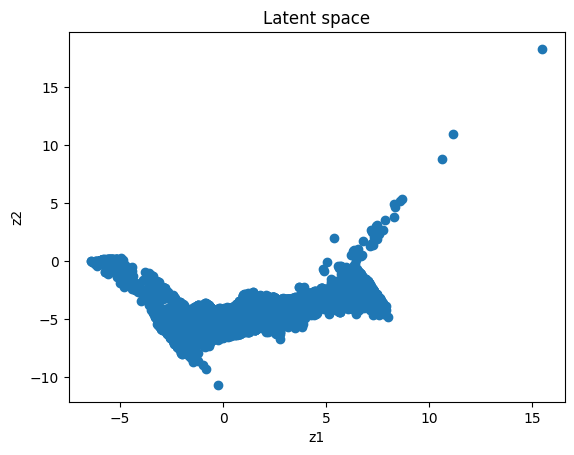

In [17]:
plt.scatter(z[:,0].cpu().tolist(), z[:,1].cpu().tolist())
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Latent space")
plt.show()

In [11]:
with torch.no_grad():
    recon = model(X.to(device))[0].cpu()

# Preform Kmeans on latent space

/Users/franciscagomes/PhD/WM_class/.venv/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


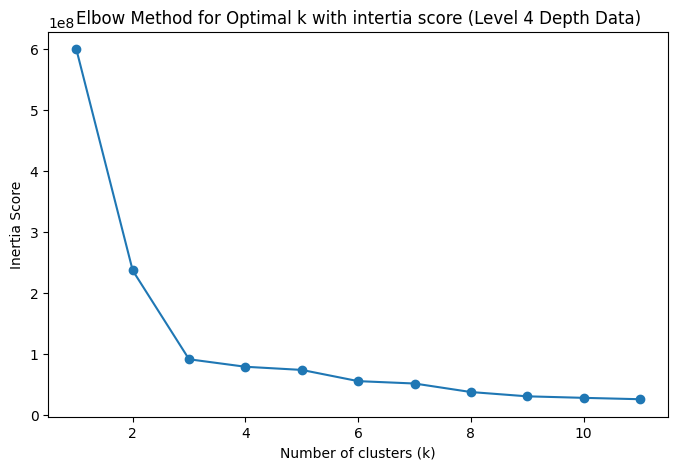

In [12]:
from sklearn.cluster import KMeans

# Elbow method for level 4 depth data
n_clusters = range(1, 12)
inertias = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=22)
    kmeans.fit(recon)
    inertia = kmeans.inertia_
    inertias.append(inertia)

# Plot elbow method
plt.figure(figsize=(8, 5))
plt.title('Elbow Method for Optimal k with intertia score (Level 4 Depth Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia Score')
plt.plot(n_clusters, inertias, marker='o')

In [56]:
import plotly.express as px

# Do kmeans clustering on latent space with k=2
kmeans = KMeans(n_clusters=3, random_state=22)
kmeans.fit(z)
labels = kmeans.labels_

In [57]:
df_recon = pd.DataFrame(recon.numpy(), columns=sampled_df.columns)

fig = px.scatter_3d(
    df_recon,
    x='Conservative_Temperature_[deg_C]', y='Absolute_Salinity_[PSU]', z='Dissolved_Oxygen_[micro_mol_per_kg]',
    color=labels,
    title="K-means on VAE Recon (50k sample)"
)
fig.show()

In [58]:
df_recon = pd.DataFrame(recon.numpy(), columns=sampled_df.columns)

In [59]:
df_recon.shape

(60643, 5)

In [60]:
df_recon['lat'] = sampled_df['lat'].values
df_recon['lon'] = sampled_df['lon'].values

In [61]:
# Plot this spatially using lat/lon from original data
# Get full dataframe with lat/lon
import plotly.express as px

# Compute data centroid (mean location)
center_lat = df_TSO['Latitude_[deg_N]'].mean()
center_lon = df_TSO['Longitude_[deg_E]'].mean()

print("Center lat:", center_lat, "Center lon:", center_lon)

fig.update_layout(height=800, width=800)
fig.show()

# Use labels from kmeans clustering on data to plot geographically
df_recon['label'] = labels.astype(str)
fig2 = px.scatter_geo(
    df_recon,
    lat='lat',
    lon='lon',
    color='label',
    title="K-means on VAE Recon (Full Data)"
)

fig2.update_geos(
    projection_type="orthographic",
    projection_rotation=dict(lat=center_lat, lon=center_lon),
    showcoastlines=True,
    showcountries=True
)

fig2.show()

Center lat: 80.17586786575905 Center lon: -91.60875191020985


In [64]:
# GMM clustering on latent space
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=22)
gmm.fit(z)
gmm_labels = gmm.predict(z)
df_recon['gmm_label'] = gmm_labels.astype(str)

# Compute data centroid (mean location)
center_lat = df_TSO['Latitude_[deg_N]'].mean()
center_lon = df_TSO['Longitude_[deg_E]'].mean()

print("Center lat:", center_lat, "Center lon:", center_lon)

# Use labels from kmeans clustering on data to plot geographically
fig3 = px.scatter_geo(
    df_recon,
    lat='lat',
    lon='lon',
    color='gmm_label',
    title="Gaussian Mixture Model on VAE lattent space geographic projection"
)

fig3.update_geos(
    projection_type="orthographic",
    projection_rotation=dict(lat=center_lat, lon=center_lon),
    showcoastlines=True,
    showcountries=True
)

fig3.update_layout(height=800, width=800)
fig3.show()


Center lat: 80.17586786575905 Center lon: -91.60875191020985


NameError: name 'df_full' is not defined